# Training set generation
## C+ class

In [8]:
%matplotlib inline
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

from vip_hci.config import VLT_NACO
from vip_hci.fm import normalize_psf, cube_inject_companions
from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus

from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap
from vip_hci.var import fit_2dgaussian, frame_center

from vip_hci.preproc.cosmetics import cube_crop_frames, frame_crop
from vip_hci.preproc import frame_rotate
from vip_hci.config.utils_conf import pool_map, iterable

import training_set_generation_functions
reload(training_set_generation_functions)
from training_set_generation_functions import inject_random_fake_comp, make_mlar_plus, make_mlar_minus, get_fwhm, evaluate_snr, plot_patch, flux_interval, patch_rotation, patch_shift, patch_average, save_to_h5, read_h5, make_residual_cube, plot_10_random

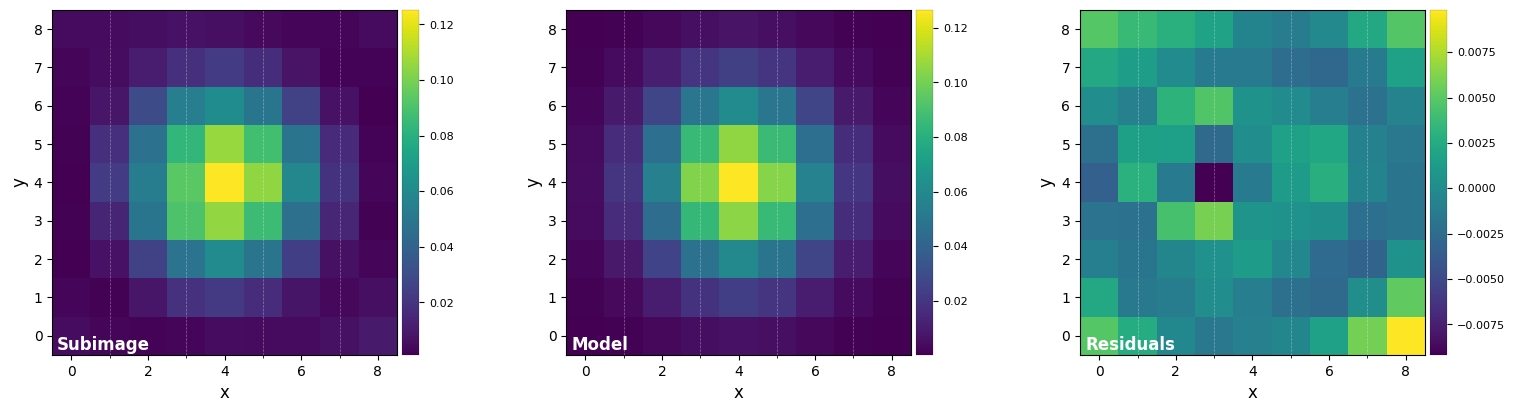

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153815
theta = 3.7772100990960773


In [9]:
adi=np.load('adi_sequence/adi_seq.npy')
pa=np.load('adi_sequence/pa.npy')
psf=np.load('adi_sequence/psf.npy')
pxscale=np.load('adi_sequence/pxscale.npy')

fwhm = get_fwhm(psf)
an_nbr=8
an_radius = an_nbr*fwhm
snr_interv=(1,3)
ncomp= 3
sample_nbr=50
flux_stat=50

In [10]:
inj_adi=[]                 #store adi cubes that have been injected with a satisfying S/N value
good_values=[]             # S/N, posx, posy corrseponding to adi cubes in inj_adi
snr_values=[]
patches_plus=[]
adi_with_fake_comp, flevel = inject_random_fake_comp(adi, psf, pxscale, pa, fwhm, an_radius, inj_nbr=flux_stat, nproc=6)

inj_pos=[(i[1][0][1],i[1][0][0]) for i in adi_with_fake_comp] # [(x,y),....] xy injection position

adi_with_fake_comp=[i[0] for i in adi_with_fake_comp]
snr_res = evaluate_snr(adi_with_fake_comp, pa, fwhm, inj_pos, an_radius, nproc=6)  #[[posy, posx,flux, array(flux_appertures), s/r],....]

#snr_values.append([snr_vale, f_source, sourcex, sourcey])
for i in range(len(snr_res)):
    if snr_res[i][4]>snr_interv[0] and snr_res[i][4]<snr_interv[1]:
        inj_adi.append(adi_with_fake_comp[i])
        good_values.append([snr_res[i][4], snr_res[i][1], snr_res[i][0]])

snr_values=[[i[4],i[2]] for i in snr_res]

Flux in 1xFWHM aperture: 0.994


Controlling S/N after random injections and evaluating mean flux interval to retreive the wanted S/N

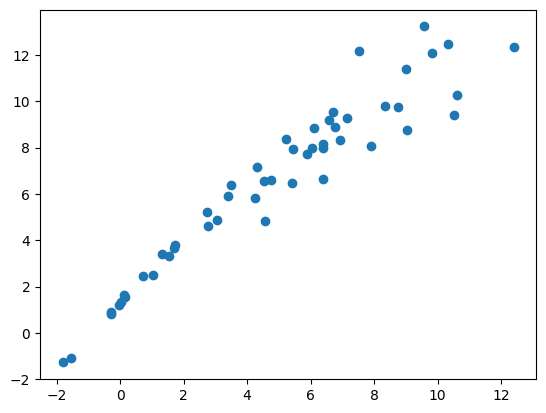

In [11]:
snr_values=np.array(snr_values)
flevel=np.array([flevel])
scatter(snr_values[:,1],snr_values[:,0])
snr_values = np.concatenate((snr_values,flevel.T), axis=1)
flux_interv = flux_interval(snr_interv, snr_values)

In [12]:
print(flux_interv)

(7.0, 10.0)


In [15]:
for i in range(len(inj_adi)):
    mlar=make_mlar_plus(inj_adi[i], ncomp, pa, fwhm, (good_values[i][1],good_values[i][2]), an_radius, nproc= 3)
    patches_plus.append(mlar)

AttributeError: 'list' object has no attribute 'ndim'

Adding patches to data set with fake companions injected randomly within the previously found flux interval in ordre to reach the numbre of samples we want

In [ ]:
diff=sample_nbr-len(mlar)
chunk_size=500
chunk_nbr=diff//chunk_size
last_ones= diff - chunk_nbr*chunk_size

# generating only 'chunk_size' numbre of samples to avoid memory error in python pooling
for j in range(chunk_nbr):
    adi_with_fake_comp, flevel = inject_random_fake_comp(adi, psf, pxscale, pa, fwhm, an_radius, inj_nbr=chunk_size, flx=flux_interv, nproc=6)
    inj_pos=[(i[1][0][1],i[1][0][0]) for i in adi_with_fake_comp]
    adi_with_fake_comp=[i[0] for i in adi_with_fake_comp]

    for i in range(len(adi_with_fake_comp)):
        mlar=make_mlar_plus(adi_with_fake_comp[i], ncomp, pa, fwhm, inj_pos[i], an_radius, plot=False)
        patches_plus.append(mlar)

#remaining samples to reach sample_nbr
adi_with_fake_comp, flevel = inject_random_fake_comp(adi, psf, pxscale, pa, fwhm, an_radius, inj_nbr=chunk_size, flx=flux_interv, nproc=6)
inj_pos=[(i[1][0][1],i[1][0][0]) for i in adi_with_fake_comp]
adi_with_fake_comp=[i[0] for i in adi_with_fake_comp]

for i in range(len(adi_with_fake_comp)):
    mlar=make_mlar_plus(adi_with_fake_comp[i], ncomp, pa, fwhm, inj_pos[i], an_radius, plot=False)
    patches_plus.append(mlar)


## C- class

In [ ]:
chunk_size=500
chunk_nbr=sample_nbr//chunk_size
last_ones= sample_nbr - chunk_nbr*chunk_size

residual_cube=make_residual_cube(adi, pa, ncomp, fwhm, an_radius)

patches_minus=[]
for i in range(chunk_nbr):
    patches_minus+=make_mlar_minus(residual_cube, fwhm, an_radius, chunk_nbr, nproc=6)
    
if last_ones!=0:
    patches_minus+=make_mlar_minus(residual_cube, fwhm, an_radius, last_ones, nproc=6)

## Data augmentation

In [ ]:
patches_minus_aug=[]
patches_plus_aug=[]

Rotation

In [ ]:
patches_minus_aug+=patch_rotation(patches_minus, nproc=6)
patches_plus_aug+=patch_rotation(patches_plus, nproc=6)

Shift

In [ ]:
patches_minus_aug+=patch_shift(patches_minus, nproc=6)
    
patches_plus_aug+=patch_shift(patches_plus, nproc=6)

Average

In [ ]:
patches_minus_aug+=patch_average(patches_minus, nproc=6)

patches_plus_aug+=patch_average(patches_plus, nproc=6)

In [ ]:
plot_10_random(patches_plus)

In [ ]:
plot_10_random(patches_minus)

In [ ]:
plot_10_random(patches_plus_aug)

In [ ]:
plot_10_random(patches_minus_aug)

## Dataset file

Save data

In [ ]:
save_to_h5(an_nbr, {'patches_plus':patches_plus, 'patches_plus_aug':patches_plus_aug, 'patches_minus':patches_minus, 'patches_minus_aug':patches_minus_aug})

Load data

In [ ]:

data_set=read_h5('training_dataset',5)
for i in data_set:
    if data_set[0]=='patches_plus':      #error use i[0] maybe?
        patches_plus=data_set[1]
    if data_set[0]=='patches_plus_aug':
        patches_plus_aug=data_set[1]
    if data_set[0]=='patches_minus':
        patches_minus=data_set[1]
    if data_set[0]=='patches_minus_aug':
        patches_minus_aug=data_set[1]
 
        

### Eye check results

In [ ]:
plot_10_random(patches_plus)

In [ ]:
plot_10_random(patches_minus)

In [ ]:
plot_10_random(patches_plus_aug)

In [ ]:
plot_10_random(patches_minus_aug)